In [1]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
import statsmodels.api as sm
from mord import LogisticIT
import seaborn as sns
from dmba import liftChart, classificationSummary, gainsChart, plotDecisionTree, regressionSummary, exhaustive_search, adjusted_r2_score, backward_elimination
from dmba.metric import AIC_score
from sklearn.svm import SVC
import math
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, auc, r2_score, confusion_matrix
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [3]:
stroke_df = pd.read_csv("healthcare.csv")

In [4]:
stroke_df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [5]:
# Convert 'age' column to integer
stroke_df['age'] = stroke_df['age'].astype(int)

# Convert 'avg_glucose_level' column to float
stroke_df['avg_glucose_level'] = stroke_df['avg_glucose_level'].astype(float)

# Convert 'hypertension' column to integer
stroke_df['hypertension'] = stroke_df['hypertension'].astype(int)

# Convert 'heart_disease' column to integer
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype(int)

In [6]:
# Create a list of the numerical columns
num_cols = ['age', 'avg_glucose_level', 'bmi']
df_num = stroke_df[num_cols]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns using the scaler
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=num_cols)

# Replace the original numerical columns with the scaled ones
stroke_df[num_cols] = df_num_scaled

In [7]:
stroke_df.dropna(subset=['age','avg_glucose_level','bmi'], inplace=True)

In [8]:
stroke_df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int32  
 4   heart_disease      4909 non-null   int32  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int32(2), int64(2), object(5)
memory usage: 460.2+ KB


In [10]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,0.522612,0.091872,0.049501,0.231674,0.212981,0.042575
std,20995.098457,0.275317,0.288875,0.216934,0.205080,0.089966,0.201917
min,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18605.000000,0.304878,0.000000,0.000000,0.101330,0.151203,0.000000
50%,37608.000000,0.536585,0.000000,0.000000,0.168775,0.203895,0.000000
75%,55220.000000,0.731707,0.000000,0.000000,0.269827,0.261168,0.000000
max,72940.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Creating a copy of the main dataframe to create a heatmap
stroke_hm = stroke_df.copy()

In [12]:
# Converting the categorical columns into numeric data for the purpose of calculating correlation
stroke_hm = pd.DataFrame(data = stroke_hm.iloc[:,1:11].values, columns = ["gender","age","hypertension","heart_disease",
                                                                          "ever_married","work_type","Residence_type",
                                                                          "avg_glucose_level","bmi","smoking_status"])
stroke_num_hm = stroke_hm.iloc[:,0:11]
le = LabelEncoder()

for i in stroke_num_hm:
    stroke_num_hm[i]=le.fit_transform(stroke_num_hm[i])
    
stroke_num_hm.head(20)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67,0,1,1,2,1,3734,239,1
1,1,80,0,1,1,2,0,2429,198,2
2,0,49,0,0,1,2,1,3309,217,3
3,0,79,1,0,1,3,0,3318,113,2
4,1,81,0,0,1,2,1,3367,163,1
5,1,74,1,1,1,2,0,579,147,2
6,0,69,0,0,0,2,1,1910,101,2
7,0,78,0,0,1,2,1,124,115,0
8,0,81,1,0,1,2,0,1140,170,2
9,0,61,0,1,1,0,0,2864,241,3


In [13]:
# Computing the correlation matrix
corr_matrix = stroke_num_hm.corr()

In [14]:
print(corr_matrix)

                     gender       age  hypertension  heart_disease  \
gender             1.000000 -0.030823      0.021578       0.082712   
age               -0.030823  1.000000      0.274329       0.256999   
hypertension       0.021578  0.274329      1.000000       0.115991   
heart_disease      0.082712  0.256999      0.115991       1.000000   
ever_married      -0.037237  0.680834      0.162406       0.111245   
work_type          0.058560 -0.367481     -0.052750      -0.030373   
Residence_type    -0.005014  0.010942     -0.001074      -0.002362   
avg_glucose_level  0.050207  0.147662      0.121306       0.107669   
bmi               -0.027717  0.349698      0.163928       0.045371   
smoking_status    -0.060004  0.275902      0.110808       0.055236   

                   ever_married  work_type  Residence_type  avg_glucose_level  \
gender                -0.037237   0.058560       -0.005014           0.050207   
age                    0.680834  -0.367481        0.010942         

<AxesSubplot:>

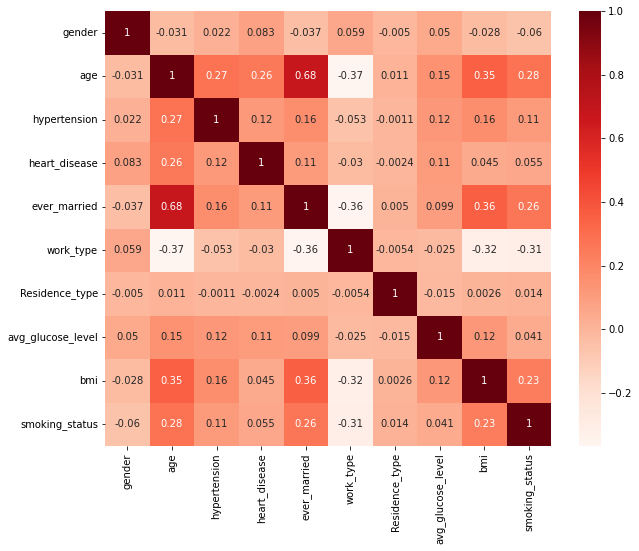

In [15]:
# Setting the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Use the heatmap() function from seaborn to create a heatmap
sns.heatmap(corr_matrix, cmap = 'Reds', annot = True, ax = ax)

Splitting the dataframe stroke_df into test and train dataframes

In [16]:
predictors = ['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']

In [17]:
#Split the data into training (60%) and testing (40%)
x = pd.get_dummies(stroke_df[predictors])
y = stroke_df['stroke']
classes = [0, 1]

# split into training and validation
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.40, random_state=1)
print(x_train)

           age  hypertension  heart_disease  avg_glucose_level       bmi  \
4369  0.634146             0              0           0.034807  0.316151   
3903  0.804878             0              0           0.221078  0.261168   
322   0.268293             0              0           0.068415  0.143184   
1617  0.853659             1              0           0.050134  0.260023   
4288  0.524390             1              0           0.008402  0.400916   
...        ...           ...            ...                ...       ...   
3036  0.487805             0              0           0.228603  0.167239   
2899  0.670732             0              0           0.063106  0.191294   
962   0.402439             0              0           0.102945  0.180985   
4157  0.170732             0              0           0.261472  0.166094   
275   0.817073             0              0           0.182301  0.207331   

      gender_Female  gender_Male  gender_Other  ever_married_No  \
4369              1 

# Naive Bayes

In [18]:
NBxtrain = x_train.copy()
NBxvalid = x_valid.copy()
NBytrain = y_train.copy()
NByvalid = y_valid.copy()

In [19]:
# Converting all the numerical columns into catergories using bins
NBxtrain.age = [round(t / 0.1) for t in NBxtrain.age]
NBxtrain.age = NBxtrain.age.astype('category')
NBxvalid.age = [round(t / 0.1) for t in NBxvalid.age]
NBxvalid.age = NBxvalid.age.astype('category')

NBxtrain.hypertension = NBxtrain.hypertension.astype('category')
NBxvalid.hypertension = NBxvalid.hypertension.astype('category')

NBxtrain.heart_disease = NBxtrain.heart_disease.astype('category')
NBxvalid.heart_disease = NBxvalid.heart_disease.astype('category')

NBxtrain.avg_glucose_level = [round(t / 0.1) for t in NBxtrain.avg_glucose_level]
NBxtrain.avg_glucose_level = NBxtrain.avg_glucose_level.astype('category')
NBxvalid.avg_glucose_level = [round(t / 0.1) for t in NBxvalid.avg_glucose_level]
NBxvalid.avg_glucose_level = NBxvalid.avg_glucose_level.astype('category')

NBxtrain.bmi = [round(t / 0.1) for t in NBxtrain.bmi]
NBxtrain.bmi = NBxtrain.bmi.astype('category')
NBxvalid.bmi = [round(t / 0.1) for t in NBxvalid.bmi]
NBxvalid.bmi = NBxvalid.bmi.astype('category')

In [20]:
x_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 2648 to 776
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             1964 non-null   float64
 1   hypertension                    1964 non-null   int32  
 2   heart_disease                   1964 non-null   int32  
 3   avg_glucose_level               1964 non-null   float64
 4   bmi                             1964 non-null   float64
 5   gender_Female                   1964 non-null   uint8  
 6   gender_Male                     1964 non-null   uint8  
 7   gender_Other                    1964 non-null   uint8  
 8   ever_married_No                 1964 non-null   uint8  
 9   ever_married_Yes                1964 non-null   uint8  
 10  work_type_Govt_job              1964 non-null   uint8  
 11  work_type_Never_worked          1964 non-null   uint8  
 12  work_type_Private               

In [21]:
x_valid.head(10)

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2648,0.634146,0,0,0.148370,0.341352,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3441,0.719512,0,0,0.161296,0.213058,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4935,0.195122,0,0,0.194396,0.232532,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
1316,0.256098,0,0,0.366217,0.215349,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3271,0.439024,0,0,0.090066,0.243986,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1628,0.841463,0,1,0.746838,0.223368,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
843,0.231707,0,0,0.133598,0.164948,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1046,0.548780,0,0,0.099714,0.215349,0,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
2721,0.207317,0,0,0.154418,0.238259,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2731,0.646341,0,0,0.085311,0.191294,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [22]:
# run naive Bayes
stroke_NB = MultinomialNB(alpha=0.01)
stroke_NB.fit(NBxtrain, NBytrain)

MultinomialNB(alpha=0.01)

In [23]:
# predict probabilities
predProb_train = stroke_NB.predict_proba(NBxtrain)
predProb_valid = stroke_NB.predict_proba(NBxvalid)

In [24]:
# predict class membership
y_valid_pred = stroke_NB.predict(NBxvalid)
y_train_pred = stroke_NB.predict(NBxtrain)

In [25]:
# Use the model to predict a new data
new_df = pd.concat([pd.DataFrame({'actual': NByvalid, 'predicted': y_valid_pred})], axis=1)
mask = ((NBxvalid.gender_Male == 1) & (NBxvalid.ever_married_Yes == 1) & (NBxvalid.work_type_Private == 1) &
        (NBxvalid.Residence_type_Urban == 1)) & (NBxvalid.smoking_status_Unknown == 1)

print(new_df[mask])

      actual  predicted
1046       0          0
1652       0          0
927        0          0
3517       0          0
989        0          0
364        0          0
1099       0          0
590        0          0
2836       0          0
1909       0          0
4108       0          0
1799       0          0
3026       0          0
1618       0          0
1607       0          0
4634       0          0
3368       0          0
2661       0          0
1401       0          0
5075       0          0
2625       0          0
67         1          0
3293       0          0
2469       0          0
1166       0          0
2044       0          0
2029       0          0
5063       0          0
4962       0          0
3302       0          0
767        0          0
5046       0          0
518        0          0
89         1          0
236        1          0
991        0          0
1700       0          0
2524       0          0
3989       0          0


In [26]:
# Calculating the accuracy score of the algorithm
accNB = accuracy_score(NByvalid, y_valid_pred)

print("Accuracy of Naive Bayes: ", accNB)

Accuracy of Naive Bayes:  0.9495926680244399


Note: We will calculate the accuracy of the algorithms based on the validation dataset as we want to know the accuracy of the predictive models on unseen and unused data

In [27]:
classificationSummary(NByvalid, y_valid_pred)

Confusion Matrix (Accuracy 0.9496)

       Prediction
Actual    0    1
     0 1862   19
     1   80    3


# K-Nearest Neighbors

In [28]:
# Merge the dataframes horizontally using the 'id' column as the key
train_KNN = pd.concat([x_train, y_train], axis=1, join='outer')
valid_KNN = pd.concat([x_valid, y_valid], axis=1, join='outer')

# Print the resulting merged dataframe
print(train_KNN.shape, valid_KNN.shape)

(2945, 22) (1964, 22)


In [29]:
newFD = pd.DataFrame([{'age': 0.24, 'bmi': 0.63}])
newFD

,age,bmi
0,0.24,0.63


In [30]:
newFD_1 = train_KNN.sample(50)

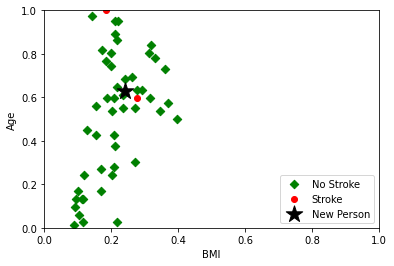

In [31]:
# Plotting the dataframe using Scatter Plot
fig, ax = plt.subplots()

subset = newFD_1.loc[newFD_1['stroke'] == 0]
ax.scatter(subset.bmi, subset.age, marker = 'D', label = 'No Stroke', color = 'green')

subset = newFD_1.loc[newFD_1['stroke'] == 1]
ax.scatter(subset.bmi, subset.age, marker = 'o', label = 'Stroke', color = 'red')

ax.scatter(newFD.age, newFD.bmi, marker = '*', label = 'New Person', color = 'black', s = 300)

plt.xlabel('BMI')
plt.ylabel('Age')

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(handles, labels, loc=4)
plt.show()

In [32]:
# Fit the KNN Model = 3
knn = NearestNeighbors (n_neighbors = 3)
knn.fit(train_KNN[['age','bmi']])
distances, indices = knn.kneighbors(newFD)

print(train_KNN.iloc[indices[0], :])

           age  hypertension  heart_disease  avg_glucose_level       bmi  \
2764  0.292683             0              0           0.140476  0.607102   
4188  0.329268             0              0           0.013111  0.619702   
672   0.207317             0              0           0.058582  0.520046   

      gender_Female  gender_Male  gender_Other  ever_married_No  \
2764              1            0             0                0   
4188              1            0             0                0   
672               1            0             0                1   

      ever_married_Yes  ...  work_type_Private  work_type_Self-employed  \
2764                 1  ...                  1                        0   
4188                 1  ...                  1                        0   
672                  0  ...                  1                        0   

      work_type_children  Residence_type_Rural  Residence_type_Urban  \
2764                   0                     0       

In [33]:
#Measuring the accuracy of different k values on validation set
train_X = train_KNN[['age', 'bmi']]
train_y = train_KNN['stroke']
valid_X = valid_KNN[['age', 'bmi']]
valid_y = valid_KNN['stroke']

In [34]:
# Train a classifier for different values of k
results = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors = k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1  0.926680
1    2  0.953157
2    3  0.947556
3    4  0.954175
4    5  0.953666
5    6  0.957230
6    7  0.956212
7    8  0.957230
8    9  0.956212
9   10  0.957230
10  11  0.956721
11  12  0.957739
12  13  0.957739
13  14  0.957739
14  15  0.957739
15  16  0.957739
16  17  0.957739
17  18  0.957739
18  19  0.957739


In [35]:
# Retrain with full dataset
stroke_X = stroke_df[['age', 'bmi']]
stroke_y = stroke_df['stroke']
knn = KNeighborsClassifier(n_neighbors = 12).fit(stroke_X, stroke_y)
distances, indices = knn.kneighbors(newFD)
print(knn.predict(newFD))
print('Distances',distances)
print('Indices', indices)
print(stroke_df.iloc[indices[0], :])

[0]
Distances [[0.05744399 0.0898603  0.11470874 0.13363277 0.13518757 0.14961533
  0.15101549 0.15817101 0.16872144 0.17826553 0.17970564 0.18384122]]
Indices [[2636 4010  624 1482  666  616  872 2027  448 1557 3381 3537]]
         id  gender       age  hypertension  heart_disease ever_married  \
2764  20292  Female  0.292683             0              0          Yes   
4188  70670  Female  0.329268             0              0          Yes   
672   31145  Female  0.207317             0              0           No   
1564   3178  Female  0.304878             0              0          Yes   
715    3590  Female  0.341463             1              0           No   
662   23551    Male  0.341463             0              0          Yes   
928   41097  Female  0.280488             1              0           No   
2136  59745  Female  0.329268             0              0          Yes   
493   66570  Female  0.280488             0              0           No   
1641  50889  Female  0.256

In [36]:
# Use the classifier to make predictions on the test set
y_pred_knn = knn.predict(valid_X)

In [37]:
# Calculating the accuracy score of the algorithm
accKNN = accuracy_score(valid_y, y_pred_knn)

print("Accuracy of K-Nearest Neighbors: ", accKNN)

Accuracy of K-Nearest Neighbors:  0.9577393075356415


In [38]:
classificationSummary(valid_y, y_pred_knn)

Confusion Matrix (Accuracy 0.9577)

       Prediction
Actual    0    1
     0 1881    0
     1   83    0


# Linear Regression

In [39]:
#Building the Linear Regressiom model based on the training data
stroke_lr = LinearRegression()
stroke_lr.fit(x_train, y_train)

LinearRegression()

In [40]:
#Printing coefficients
print(pd.DataFrame({'Predictor': x.columns, 'Coefficient': stroke_lr.coef_}))

                         Predictor   Coefficient
0                              age  2.132360e-01
1                     hypertension  2.573706e-02
2                    heart_disease  8.105342e-02
3                avg_glucose_level  7.405295e-02
4                              bmi -4.368551e-02
5                    gender_Female  3.495648e+13
6                      gender_Male  3.495648e+13
7                     gender_Other  3.495648e+13
8                  ever_married_No  2.009163e+12
9                 ever_married_Yes  2.009163e+12
10              work_type_Govt_job -3.943565e+11
11          work_type_Never_worked -3.943565e+11
12               work_type_Private -3.943565e+11
13         work_type_Self-employed -3.943565e+11
14              work_type_children -3.943565e+11
15            Residence_type_Rural -2.619492e+12
16            Residence_type_Urban -2.619492e+12
17          smoking_status_Unknown -7.448599e+11
18  smoking_status_formerly smoked -7.448599e+11
19     smoking_statu

In [41]:
#Printing the performance measures (training data)
regressionSummary(y_train, stroke_lr.predict(x_train))


Regression statistics

               Mean Error (ME) : -0.0021
Root Mean Squared Error (RMSE) : 0.1945
     Mean Absolute Error (MAE) : 0.0871


In [42]:
#Using the predict() to make predictions on a new set
stroke_lr_pred = stroke_lr.predict(x_valid)
result = pd.DataFrame({'Predicted': stroke_lr_pred, 'Actual': y_valid, 'Residual': y_valid - stroke_lr_pred})
print(result.head(20))

      Predicted  Actual  Residual
2648   0.058594       0 -0.058594
3441   0.039062       0 -0.039062
4935   0.007812       0 -0.007812
1316  -0.003906       0  0.003906
3271   0.031250       0 -0.031250
1628   0.250000       0 -0.250000
843   -0.058594       0  0.058594
1046   0.027344       0 -0.027344
2721  -0.015625       0  0.015625
2731   0.027344       0 -0.027344
563    0.097656       0 -0.097656
1155   0.015625       0 -0.015625
1538   0.000000       0  0.000000
4161   0.042969       0 -0.042969
4311   0.101562       0 -0.101562
1078   0.027344       0 -0.027344
2551  -0.019531       0  0.019531
3000   0.011719       0 -0.011719
4610  -0.015625       0  0.015625
1302   0.062500       0 -0.062500


In [43]:
#Printing the performace measures (validation data)
regressionSummary(y_valid, stroke_lr.predict(x_valid))


Regression statistics

               Mean Error (ME) : -0.0017
Root Mean Squared Error (RMSE) : 0.1948
     Mean Absolute Error (MAE) : 0.0873


In [44]:
#Validation Error - Evaluate Perfomance
stroke_lr_pred = stroke_lr.predict(x_valid)
all_residuals = y_valid - stroke_lr_pred

In [45]:
#Determining the percentage of datapoint with a residual in [-0.2, 0.2]
resLR1 = len(all_residuals[(all_residuals > -0.2) & (all_residuals < 0.2)]) / len(all_residuals)

print(resLR1)

0.9394093686354379


SUSBSET SELECTION ALGORITHM

In [46]:
def train_model(variables):
    model = LinearRegression()
    model.fit(x_train[list(variables)], y_train)
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(x_train[variables]), model)

In [47]:
allVariables = x_train.columns
best_model, best_variables = backward_elimination(allVariables, train_model, score_model, verbose=True)

Variables: age, hypertension, heart_disease, avg_glucose_level, bmi, gender_Female, gender_Male, gender_Other, ever_married_No, ever_married_Yes, work_type_Govt_job, work_type_Never_worked, work_type_Private, work_type_Self-employed, work_type_children, Residence_type_Rural, Residence_type_Urban, smoking_status_Unknown, smoking_status_formerly smoked, smoking_status_never smoked, smoking_status_smokes
Start: score=-1239.83
Step: score=-1278.27, remove gender_Female
Step: score=-1280.27, remove ever_married_No
Step: score=-1282.41, remove work_type_Govt_job
Step: score=-1284.32, remove smoking_status_never smoked
Step: score=-1286.27, remove Residence_type_Rural
Step: score=-1288.24, remove gender_Other
Step: score=-1289.59, remove work_type_Never_worked
Step: score=-1290.51, remove smoking_status_formerly smoked
Step: score=-1291.14, remove gender_Male
Step: score=-1291.74, remove Residence_type_Urban
Step: score=-1292.21, remove work_type_Self-employed
Step: score=-1292.75, remove bmi

In [48]:
print(best_variables)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married_Yes', 'work_type_Private', 'work_type_children', 'smoking_status_Unknown']


In [49]:
regressionSummary(y_valid, best_model.predict(x_valid[best_variables]))


Regression statistics

               Mean Error (ME) : 0.0003
Root Mean Squared Error (RMSE) : 0.1941
     Mean Absolute Error (MAE) : 0.0842


# CART

In [50]:
CART_x_train = x_train.copy()
CART_x_valid = x_valid.copy()
CART_y_train = y_train.copy()
CART_y_valid = y_valid.copy()

In [51]:
# Create a decision tree classifier
CARTmodel=DecisionTreeClassifier(criterion='gini')
CARTmodel.fit(CART_x_train,CART_y_train)
if CARTmodel.predict([[0.6341446,0,0,0,0.034807,0.316151,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0]])==0:
    print("yes, there is a risk of stroke")
else:
    print("No, there's no risk of stroke")

yes, there is a risk of stroke


C:\Users\guruk\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [52]:
X_new = [[0.6341446,0,0,0,0.034807,0.316151,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0]]
y_pred = CARTmodel.predict(X_new)
print(y_pred)

[0]


C:\Users\guruk\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [53]:
# predict class membership
y_valid_pred_CART = CARTmodel.predict(CART_x_valid)

In [54]:
CART_accuracy = accuracy_score(CART_y_valid, y_valid_pred)
print(CART_accuracy)

0.9495926680244399


In [55]:
classificationSummary(CART_y_valid, y_valid_pred_CART)

Confusion Matrix (Accuracy 0.9170)

       Prediction
Actual    0    1
     0 1790   91
     1   72   11


# Logistic Regression

In [56]:
LR_x_train = x_train.copy()
LR_x_valid = x_valid.copy()
LR_y_train = y_train.copy()
LR_y_valid = y_valid.copy()

In [57]:
# Fitting a logistic regression model
LRmodel = LogisticRegression(max_iter =1000)
LRmodel.fit(LR_x_train, LR_y_train)

LogisticRegression(max_iter=1000)

In [58]:
# Making predictions on the testing data
y_pred_logit = LRmodel.predict(LR_x_valid)

In [59]:
# Evaluating the model
accuracy = accuracy_score(LR_y_valid, y_pred_logit)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 95.77%


In [60]:
### confusion matrix to visualize the performance of model


import seaborn as sns
from sklearn.metrics import confusion_matrix

In [61]:
# Creating a confusion matrix
cm = confusion_matrix(LR_y_valid, y_pred_logit)

<AxesSubplot:>

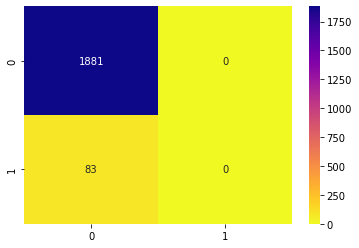

In [62]:
# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma_r')

In [63]:
# Calculating the probabilities for each class
y_prob = LRmodel.predict_proba(LR_x_valid)[:, 1]

In [64]:
# Calculating the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(LR_y_valid, y_prob)

In [65]:
# Calculating the area under the ROC curve
roc_auc = auc(fpr, tpr)

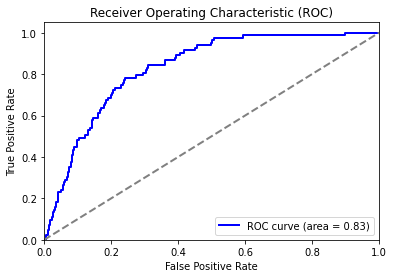

In [66]:
# Plotting the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

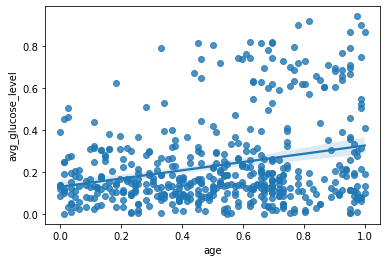

In [67]:
stroke_df_sam = stroke_df.sample(500)

# Create a regplot
sns.regplot(x='age', y='avg_glucose_level', data=stroke_df_sam)

In [68]:
classificationSummary(LR_y_valid, y_pred_logit)

Confusion Matrix (Accuracy 0.9577)

       Prediction
Actual    0    1
     0 1881    0
     1   83    0


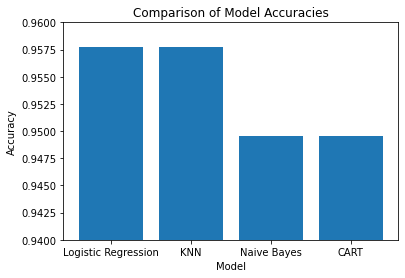

In [69]:
# Create a bar graph comparing the accuracy scores
models = ['Logistic Regression', 'KNN', 'Naive Bayes', 'CART']
accuracies = [accuracy, accKNN, accNB, CART_accuracy]

plt.bar(models, accuracies)
plt.ylim(0.94, 0.96)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()